In [1]:
!git clone https://github.com/mhsefidgar/DinoV3Production.git
%cd  DinoV3Production
!pip install -e .
!pip install rembg


Cloning into 'DinoV3Production'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 134 (delta 54), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (134/134), 409.60 KiB | 2.13 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/DinoV3Production
Obtaining file:///content/DinoV3Production
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.0 MB/s eta 0:00:00
  Running setup.py develop for dinov3production


# Dense and Sparse Correspondence

Establishes correspondences between two objects using DINOv3 features.

In [2]:
import dinov3production

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from PIL import Image
import urllib
from tqdm import tqdm
from sklearn.decomposition import PCA

from dinov3production import create_model
from dinov3production.data.transforms import resize_to_patch_multiple
from dinov3production.matching import stratify_points
import torchvision.transforms.functional as TF

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Model
# We use ViT-S/14 for Colab stability (low memory usage).
# You can switch to 'dinov3_vitl14' (Large) or 'dinov3_vitg14' (Giant) if you have enough VRAM.
model = create_model('dinov3_vits14', pretrained=True)
model.to(device)
model.eval()

PATCH_SIZE = 14 # Match model patch size
IMAGE_SIZE = 768

Loading pretrained weights for dinov3_vits14...


## 1. Data Loading

Loaded images and generated masks using rembg!


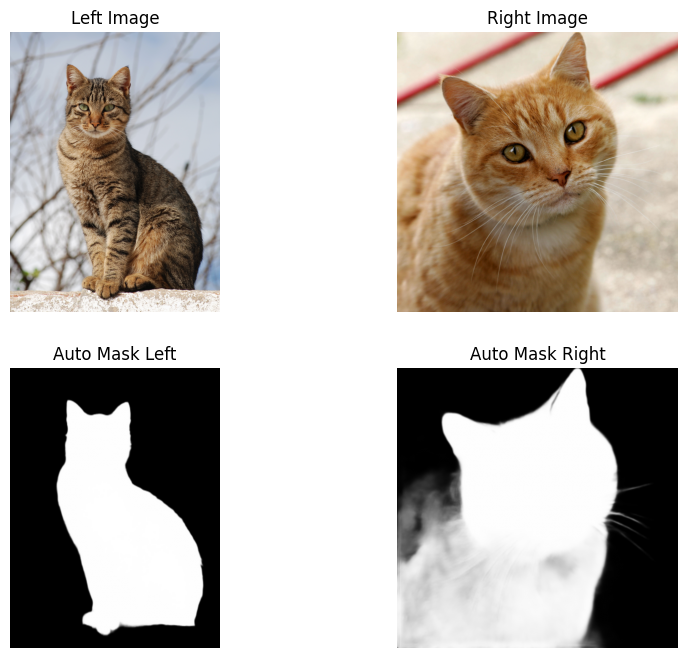

In [10]:
from PIL import Image
import urllib.request
import matplotlib.pyplot as plt
import io
import numpy as np
import torch
from rembg import remove

def load_image_from_url(url: str) -> Image.Image:
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'}
    req = urllib.request.Request(url, headers=headers)
    with urllib.request.urlopen(req) as f:
        # Load and ensure it is RGB for rembg
        return Image.open(f).convert("RGB")

def get_auto_mask(img: Image.Image):
    """
    Uses rembg to identify the object and return a grayscale mask.
    """
    # remove() returns an RGBA image where background alpha is 0
    output_rgba = remove(img)

    # Extract the Alpha channel as the mask (L mode)
    mask = output_rgba.split()[-1]

    return mask

image_left_uri = "https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg"
image_right_uri = "https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg"

try:
    # 1. Load Original Images
    image_left = load_image_from_url(image_left_uri)
    image_right = load_image_from_url(image_right_uri)

    # 2. Generate Masks automatically using rembg
    mask_left = get_auto_mask(image_left)
    mask_right = get_auto_mask(image_right)

    print("Loaded images and generated masks using rembg!")

except Exception as e:
    print(f"Failed to load or process images: {e}")
    # Fallback to dummy data
    image_left = Image.new('RGB', (800, 600), color='gray')
    mask_left = Image.new('L', (800, 600), color=0)
    image_right = Image.new('RGB', (800, 600), color='gray')
    mask_right = Image.new('L', (800, 600), color=0)

# Visualization to verify the background removal worked
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1); plt.imshow(image_left); plt.title("Left Image")
plt.axis('off')
plt.subplot(2, 2, 2); plt.imshow(image_right); plt.title("Right Image")
plt.axis('off')
plt.subplot(2, 2, 3); plt.imshow(mask_left, cmap='gray'); plt.title("Auto Mask Left")
plt.axis('off')
plt.subplot(2, 2, 4); plt.imshow(mask_right, cmap='gray'); plt.title("Auto Mask Right")
plt.axis('off')
plt.show()

## 2. Feature Extraction

In [11]:
patch_quant_filter = torch.nn.Conv2d(1, 1, PATCH_SIZE, stride=PATCH_SIZE, bias=False)
patch_quant_filter.weight.data.fill_(1.0 / (PATCH_SIZE * PATCH_SIZE))

patch_mask_values = []
patch_features = []

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def extract_dino_features(model, x):
    # x: [B, 3, H, W]
    B, _, H, W = x.shape
    # Forward pass to get all tokens: [B, N_tokens, D]
    # Tokens layout: [CLS, REG_1...REG_K, PATCH_1...PATCH_N]
    with torch.cuda.amp.autocast(enabled=True):
        out = model.forward_features(x)

    # Get number of register tokens (safely handle if attribute missing)
    n_reg = getattr(model, 'num_register_tokens', 0)

    # Slice: Skip CLS (1) and Registers (n_reg)
    patch_tokens = out[:, 1+n_reg:]

    # Reshape to spatial grid
    h = H // PATCH_SIZE
    w = W // PATCH_SIZE
    feats = patch_tokens.reshape(B, h, w, -1)
    return feats.permute(0, 3, 1, 2) # [B, D, H, W]

with torch.inference_mode():
     for image, mask in [(image_left, mask_left), (image_right, mask_right)]:
         # Mask processing
         mask = mask.convert('L')
         mask_resized = resize_to_patch_multiple(mask, PATCH_SIZE, IMAGE_SIZE)
         mask_quantized = patch_quant_filter(mask_resized).squeeze().detach().cpu()
         patch_mask_values.append(mask_quantized)

         # Image processing
         image_resized = resize_to_patch_multiple(image, PATCH_SIZE, IMAGE_SIZE)
         image_norm = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD).unsqueeze(0).to(device)

         # Real Feature Extraction
         feats = extract_dino_features(model, image_norm)
         patch_features.append(feats.squeeze(0).detach().cpu())

/tmp/ipython-input-34978732.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


In [12]:
import torchvision.transforms.functional as TF
import torch
from PIL import Image

def resize_for_dinov3(img: Image.Image, patch_size: int, target_size: int) -> torch.Tensor:
    """
    Resize an image to target_size, then pad if necessary to be divisible by patch_size.
    Returns a [1, C, H, W] tensor on the specified device.
    """
    # Resize to target_size
    img_resized = TF.resize(img, [target_size, target_size])

    # Convert to tensor
    img_tensor = TF.to_tensor(img_resized)  # [C, H, W]
    H, W = img_tensor.shape[1], img_tensor.shape[2]

    # Pad to multiple of PATCH_SIZE if necessary
    pad_h = (patch_size - H % patch_size) % patch_size
    pad_w = (patch_size - W % patch_size) % patch_size
    if pad_h > 0 or pad_w > 0:
        img_tensor = TF.pad(img_tensor, (0, 0, pad_w, pad_h))  # right, bottom

    return img_tensor.unsqueeze(0)  # [1, C, H, W]


In [13]:
from dinov3production.core import models
dir(models.vit)


['DinoV3VisionTransformer',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_create_dinov3_model',
 'dinov3_vit7b14',
 'dinov3_vit7b16',
 'dinov3_vitb14',
 'dinov3_vitb16',
 'dinov3_vitb8',
 'dinov3_vitg14',
 'dinov3_vitl14',
 'dinov3_vitl16',
 'dinov3_vitl8',
 'dinov3_vits14',
 'dinov3_vits16',
 'dinov3_vits8',
 'nn',
 'partial',
 'register_model']

## 3. Matching Patches

In [14]:
MASK_FG_THRESHOLD = 0.5
dim = patch_features[0].shape[0]

feat0 = F.normalize(patch_features[0], p=2, dim=0)
feat1 = F.normalize(patch_features[1], p=2, dim=0)

heatmaps = torch.einsum("k h w, k i j -> h w i j", feat0, feat1)
heatmaps = heatmaps.flatten(start_dim=2) # [H, W, H2*W2]

# Find best match for each patch in Image 1
max_val, max_idx = heatmaps.max(dim=-1)

# Coordinates
h1, w1 = feat0.shape[1:]
h2, w2 = feat1.shape[1:]

patch_indices_left = torch.arange(h1*w1).reshape(h1, w1)
locs_2d_left = torch.stack((patch_indices_left // w1, patch_indices_left % w1), dim=-1).float() + 0.5
locs_2d_left *= PATCH_SIZE

patch_indices_right = max_idx # [h1, w1]
locs_2d_right = torch.stack((patch_indices_right // w2, patch_indices_right % w2), dim=-1).float() + 0.5
locs_2d_right *= PATCH_SIZE

# Filter Foreground
mask1 = (patch_mask_values[0] > MASK_FG_THRESHOLD)
mask2_vals = patch_mask_values[1].view(-1)
mask2_mapped = mask2_vals[max_idx.view(-1)].view(h1, w1) > MASK_FG_THRESHOLD

selection = mask1 & mask2_mapped

locs_2d_left_fg = locs_2d_left[selection]
locs_2d_right_fg = locs_2d_right[selection]

print(f"Selected {len(locs_2d_left_fg)} matches.")

Selected 732 matches.


## 4. Dense Correspondence (Rainbow PCA)

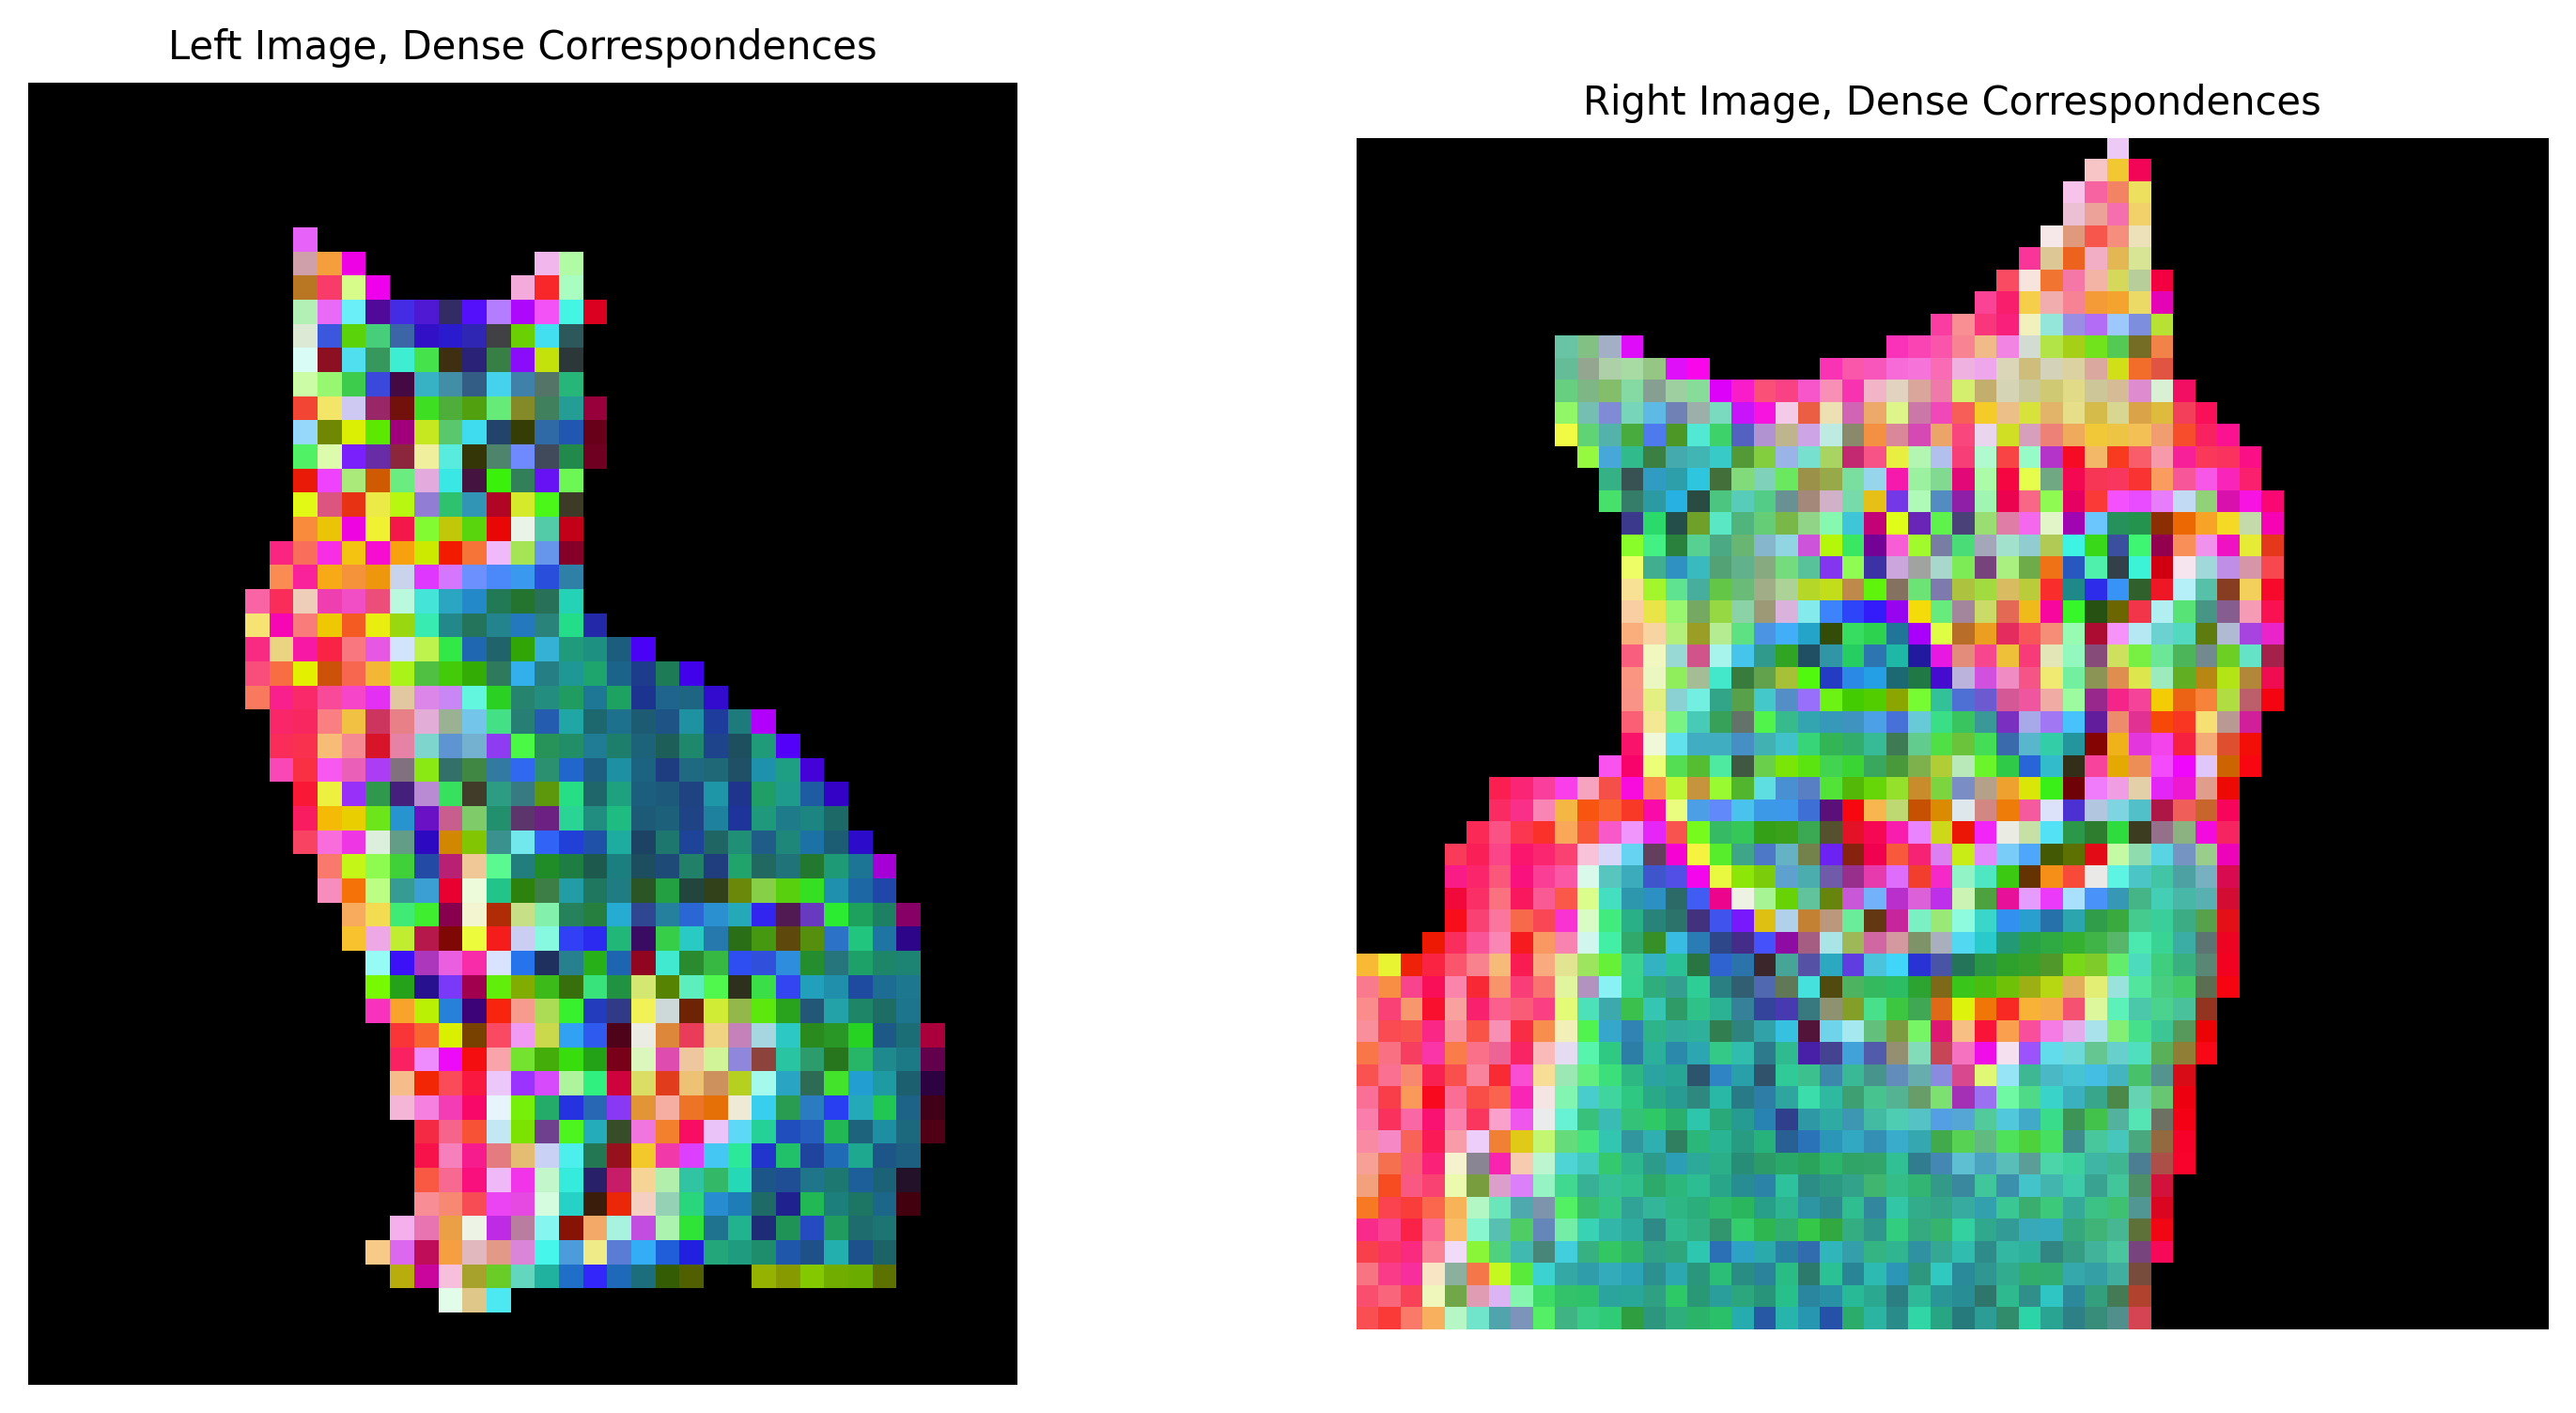

In [20]:
# 1. Re-calculate the selection mask as defined in the tutorial
MASK_FG_THRESHOLD = 0.5
n_patches_left = patch_features[0].shape[1] * patch_features[0].shape[2]

# Compute which patches are foreground in the left image
patches_left_fg_selection = (patch_mask_values[0].view(-1) > MASK_FG_THRESHOLD)

# To visualize dense correspondence, we fit PCA on all foreground patches of the left image
pca = PCA(n_components=3, whiten=True)
fg_patches_left = patch_features[0].view(dim, -1).permute(1, 0)[patches_left_fg_selection]

if len(fg_patches_left) > 3:
    # Fit PCA on the left foreground
    pca.fit(fg_patches_left.cpu().numpy())

    # --- Visualize Left ---
    h1, w1 = patch_features[0].shape[1], patch_features[0].shape[2]
    x_left = patch_features[0].view(dim, -1).permute(1, 0)
    projected_image_left = torch.from_numpy(pca.transform(x_left.cpu().numpy())).view(h1, w1, 3)
    # Vibrant color scaling
    projected_image_left = torch.nn.functional.sigmoid(projected_image_left.mul(2.0)).permute(2, 0, 1)
    # Apply left mask
    projected_image_left *= (patch_mask_values[0] > MASK_FG_THRESHOLD).float()

    # --- Visualize Right (Corrected) ---
    h2, w2 = patch_features[1].shape[1], patch_features[1].shape[2]
    x_right = patch_features[1].view(dim, -1).permute(1, 0)
    # Project Right features into the Left PCA space
    projected_image_right = torch.from_numpy(pca.transform(x_right.cpu().numpy())).view(h2, w2, 3)
    projected_image_right = torch.nn.functional.sigmoid(projected_image_right.mul(2.0)).permute(2, 0, 1)
    # Apply right mask to ensure background is hidden
    projected_image_right *= (patch_mask_values[1] > MASK_FG_THRESHOLD).float()

    # Display results
    plt.figure(figsize=(12, 6), dpi=300)
    plt.subplot(1, 2, 1)
    plt.imshow(projected_image_left.permute(1, 2, 0))
    plt.title("Left Image, Dense Correspondences", fontsize=10)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(projected_image_right.permute(1, 2, 0))
    plt.title("Right Image, Dense Correspondences", fontsize=10)
    plt.axis('off')
    plt.show()

## 5. Sparse Correspondence

Stratified: 80 points


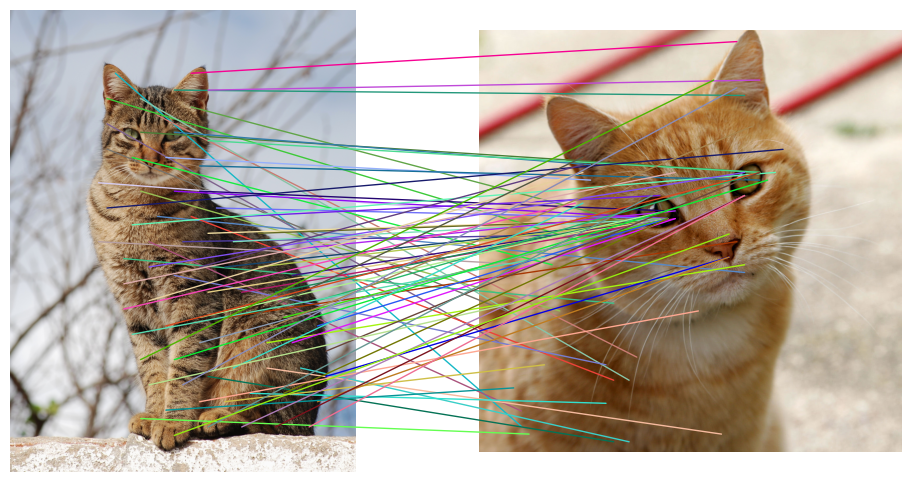

In [22]:
if len(locs_2d_left_fg) > 0:
    scale_left = image_left.height / IMAGE_SIZE
    scale_right = image_right.height / IMAGE_SIZE

    # Use library function for stratification
    ids_ex, ids_keep = stratify_points(locs_2d_left_fg * scale_left, threshold=100.0**2)

    pts_left = locs_2d_left_fg[ids_keep]
    pts_right = locs_2d_right_fg[ids_keep]

    print(f"Stratified: {len(pts_left)} points")

    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121)
    ax1.imshow(image_left)
    ax1.axis('off')
    ax2 = fig.add_subplot(122)
    ax2.imshow(image_right)
    ax2.axis('off')

    for i in range(len(pts_left)):
        r1, c1 = pts_left[i]
        r2, c2 = pts_right[i]

        color = np.random.rand(3,)
        con = ConnectionPatch(
            xyA=(c1*scale_left, r1*scale_left),
            xyB=(c2*scale_right, r2*scale_right),
            coordsA='data', coordsB='data',
            axesA=ax1, axesB=ax2, color=color
        )
        ax2.add_artist(con)
    plt.show()